In [1]:
import random
import numpy as np

SEED = 93
np.random.seed(SEED)
random.seed(SEED)

In [2]:
import torch

if torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cuda')

In [3]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

id2label = {0: "Negative", 1: "Positive"}
label2id = {v: k for k, v in id2label.items()}

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=len(id2label), id2label=id2label, label2id=label2id
).to(device)

model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [4]:
from datasets import load_dataset

data_dict = {
    "train": "yelp_train_balanced.parquet",
    "eval": "yelp_eval.parquet",
    "test": "yelp_test.parquet"
}

yelp_batrain_data = load_dataset("parquet", data_files=data_dict, split="train")
yelp_eval_data = load_dataset("parquet", data_files=data_dict, split="eval")
yelp_batrain_data = yelp_batrain_data.filter(lambda x: x["label"] != 3)
yelp_eval_data = yelp_eval_data.filter(lambda x: x["label"] != 3)
yelp_batrain_data

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 217928
})

In [5]:
from transformers import DataCollatorWithPadding, AutoTokenizer
from common import tokenize_and_label

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
yelp_batrain_data = yelp_batrain_data.map(lambda x: tokenize_and_label(tokenizer, x), 
                                          batched=True)
yelp_eval_data = yelp_eval_data.map(lambda x: tokenize_and_label(tokenizer, x), 
                                    batched=True)
yelp_eval_data["label"][:5]

[1, 0, 1, 0, 1]

In [6]:
from common import compute_accuracy

BATCH_TRAIN = 32
BATCH_EVAL = 32
GRADIENT_STEP = 1
LEARNING_RATE = 1e-4
EPOCHS = 4
LAMBDA = 0.01

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="yelp-distil-bert-sbal",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_TRAIN,
    per_device_eval_batch_size=BATCH_EVAL,
    gradient_accumulation_steps=GRADIENT_STEP,
    gradient_checkpointing=False,
    num_train_epochs=EPOCHS,
    weight_decay=LAMBDA,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    seed=SEED
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=yelp_batrain_data,
    eval_dataset=yelp_eval_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_accuracy
)

try:
    results = trainer.train(resume_from_checkpoint = True)
except ValueError:
    results = trainer.train(resume_from_checkpoint = False)

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Balanced Accuracy,Roc Auc,Kappa,F1
4,0.019500,0.296152,0.950406,0.950406,0.889963,0.952280


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



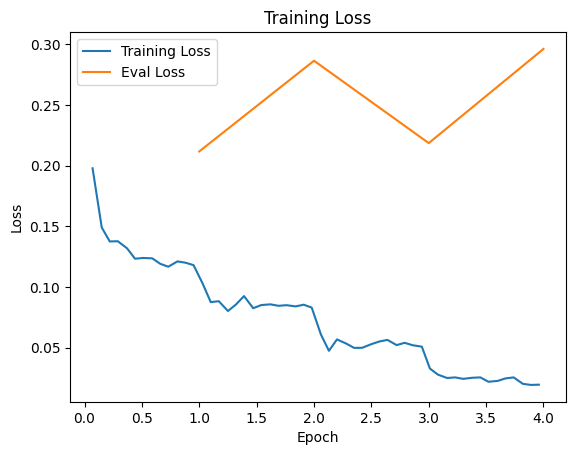

In [7]:
from common import plot_training

plot_training(trainer)

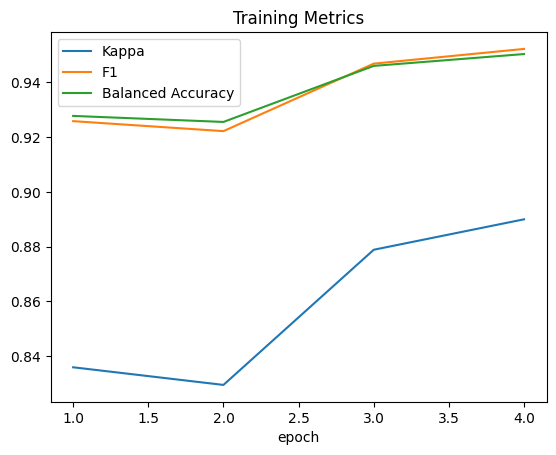

In [8]:
from common import plot_eval

plot_eval(trainer)

In [9]:
from common import test_inference

yelp_test = load_dataset("parquet", data_files=data_dict, split="test")
yelp_test = yelp_test.filter(lambda x: x["label"] != 3)
yelp_test = test_inference(tokenizer, model, device, yelp_test, BATCH_EVAL)
yelp_test = yelp_test.map(lambda batch: {"label": 1 * np.array(batch["label"]) >= 4}, 
                          batched=True, batch_size=BATCH_EVAL)

Map:   0%|          | 0/118794 [00:00<?, ? examples/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



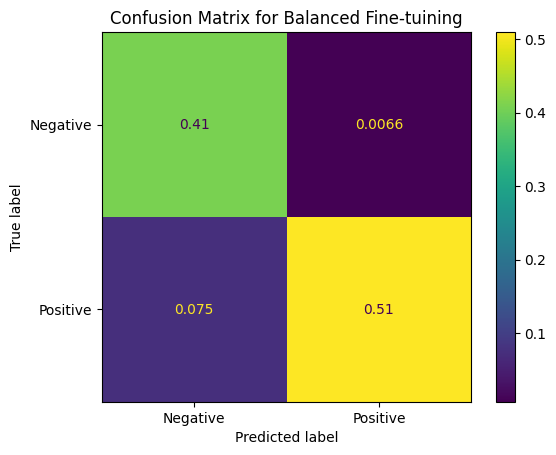

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_true=yelp_test["label"], 
                                        y_pred=yelp_test["predicted"], 
                                        display_labels=["Negative", "Positive"], 
                                        normalize="all"
                                       )
plt.title("Confusion Matrix for Balanced Fine-tuining")
plt.show()

In [11]:
from sklearn.metrics import classification_report

print(classification_report(y_true=yelp_test["label"], 
                            y_pred=yelp_test["predicted"], 
                            target_names=["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.85      0.98      0.91     49369
    Positive       0.99      0.87      0.93     69425

    accuracy                           0.92    118794
   macro avg       0.92      0.93      0.92    118794
weighted avg       0.93      0.92      0.92    118794



In [12]:
compute_accuracy([yelp_test["predicted_scores"], yelp_test["label"]])

{'balanced_accuracy': 0.928206715745871,
 'roc_auc': 0.928206715745871,
 'kappa': 0.8366302330626494,
 'f1': 0.9262051878135323}